# New Zealand Time-series Forecasting Model

# Pre-processing and Modeling 

In this notebook we are going to do pre-processing and modeling on our time-series data. We are going to decide what we want to focus on with this modeling. 

We'll start with the tourism arrivals data and then look at the accomodation data. 

We will beging by importing the necessary packages for looking at the data and creating our models.

[1.0 Tourism Data](#1.0-Tourism-Data)

[2.0 Accomodation Data](#2.0-Accomodation-Data)

In [1]:
# Import data processing packages
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.metrics import mean_squared_error

#Time Series Packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

#Modeling packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime as dt

#Visualization 
import matplotlib. pyplot as plt
import seaborn as sns

# 1.0 Tourism Data
For our `arrivals` data we are going to look at the following regions as these have the most complete time-series data:
> - Auckland
> - Christchurch
> - Wellington
> - Queenstown
> - All New Zealand Ports
    
For each of these regions, we are going to look at the following reasons for travel:
> - Business
> - Holiday
> - Visiting Friends
> - Total Travel

We want to create the most complete picture that we can for our forecasting and making sure we work on creating as thorough of a forecasting as we can. 

In [2]:
## Load our Tourism Data
# Remove extra white space at end of column

arrivals = pd.read_csv('../NZ Data/Arrivals Data Cleaned.csv', skipinitialspace = True, parse_dates = True, \
                       index_col = 0)
arrivals.columns = arrivals.columns.str.replace(r' $','', regex = True)
arrivals.columns

Index(['BusinessAuckland', 'BusinessChristchurch', 'BusinessDunedin',
       'BusinessHamilton', 'BusinessPalmerston North', 'BusinessRotorua',
       'BusinessWellington', 'BusinessQueenstown',
       'BusinessTOTAL NEW ZEALAND PORTS', 'Holiday/VacationAuckland',
       'Holiday/VacationChristchurch', 'Holiday/VacationDunedin',
       'Holiday/VacationHamilton', 'Holiday/VacationPalmerston North',
       'Holiday/VacationRotorua', 'Holiday/VacationWellington',
       'Holiday/VacationQueenstown', 'Holiday/VacationTOTAL NEW ZEALAND PORTS',
       'Visit Friends/RelativesAuckland',
       'Visit Friends/RelativesChristchurch', 'Visit Friends/RelativesDunedin',
       'Visit Friends/RelativesHamilton',
       'Visit Friends/RelativesPalmerston North',
       'Visit Friends/RelativesRotorua', 'Visit Friends/RelativesWellington',
       'Visit Friends/RelativesQueenstown',
       'Visit Friends/RelativesTOTAL NEW ZEALAND PORTS',
       'TOTAL ALL TRAVEL PURPOSESAuckland',
       'TOTAL ALL

In [5]:
# Check to make sure index is datetime
arrivals.index

DatetimeIndex(['1978-04-01', '1978-05-01', '1978-06-01', '1978-07-01',
               '1978-08-01', '1978-09-01', '1978-10-01', '1978-11-01',
               '1978-12-01', '1979-01-01',
               ...
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01'],
              dtype='datetime64[ns]', name='Date', length=530, freq=None)

In [6]:
arrivals.head()

,BusinessAuckland,BusinessChristchurch,BusinessDunedin,BusinessHamilton,BusinessPalmerston North,BusinessRotorua,BusinessWellington,BusinessQueenstown,BusinessTOTAL NEW ZEALAND PORTS,Holiday/VacationAuckland,...,Visit Friends/RelativesTOTAL NEW ZEALAND PORTS,TOTAL ALL TRAVEL PURPOSESAuckland,TOTAL ALL TRAVEL PURPOSESChristchurch,TOTAL ALL TRAVEL PURPOSESDunedin,TOTAL ALL TRAVEL PURPOSESHamilton,TOTAL ALL TRAVEL PURPOSESPalmerston North,TOTAL ALL TRAVEL PURPOSESRotorua,TOTAL ALL TRAVEL PURPOSESWellington,TOTAL ALL TRAVEL PURPOSESQueenstown,TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS
Date,,,,,,,,,,,,,,,,,,,,,
1978-04-01,3428.0,468.0,0.0,0.0,0.0,0.0,492.0,0.0,4408.0,10476.0,...,3324.0,19856.0,6240.0,0.0,0.0,0.0,0.0,2116.0,0.0,28524.0
1978-05-01,2264.0,524.0,0.0,0.0,0.0,0.0,428.0,0.0,3236.0,7168.0,...,3568.0,15428.0,5240.0,0.0,0.0,0.0,0.0,2156.0,0.0,23060.0
1978-06-01,2136.0,280.0,0.0,0.0,0.0,0.0,384.0,0.0,2880.0,4640.0,...,2600.0,11416.0,2708.0,0.0,0.0,0.0,0.0,1252.0,0.0,15760.0
1978-07-01,2156.0,324.0,0.0,0.0,0.0,0.0,380.0,0.0,2964.0,6184.0,...,3144.0,14072.0,4900.0,0.0,0.0,0.0,0.0,1480.0,0.0,20892.0
1978-08-01,2304.0,536.0,0.0,0.0,0.0,0.0,496.0,0.0,3416.0,8236.0,...,4204.0,17960.0,7900.0,0.0,0.0,0.0,0.0,2748.0,0.0,28992.0


In [4]:
# Load our model results from the pycaret notebook to look at which models might work best for us
potential_models = pd.read_csv('../NZ Data/model_results.csv')
potential_models

,Model,MAE,RMSE,MAPE,SMAPE,MASE,RMSSE,R2,TT (Sec),time_series,Unnamed: 10
0,exp_smooth,Exponential Smoothing,1847.4689,3039.9658,8.729000e+00,0.1226,2.1200,2.6891,0.5611,0.0633,BusinessAuckland
1,lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,292.8787,448.0243,1.619680e+17,0.1555,1.2487,1.4706,0.4044,0.0200,BusinessChristchurch
2,huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,23.9385,29.7550,2.358380e+16,0.5721,1.2396,0.8072,-0.4410,0.0200,BusinessDunedin
3,naive,Naive Forecaster,0.5139,2.4227,5.560000e-02,0.1111,0.0278,0.0721,-0.0580,0.0067,BusinessHamilton
4,naive,Naive Forecaster,0.0000,0.0000,0.000000e+00,0.0000,0.0000,0.0000,1.0000,0.0067,BusinessPalmerston North
5,naive,Naive Forecaster,1.5556,4.2164,5.560000e-02,0.1111,0.4877,0.3525,0.6141,0.0067,BusinessRotorua
6,exp_smooth,Exponential Smoothing,327.1570,525.1005,1.773290e+17,0.1483,1.4471,1.7904,0.4470,0.0400,BusinessWellington
7,ets,ETS,119.2602,168.2450,8.942970e+16,0.2367,3.7151,2.4567,0.2016,0.0300,BusinessQueenstown
8,exp_smooth,Exponential Smoothing,2357.5204,3906.6538,9.945200e+00,0.1204,2.1446,2.6790,0.5671,0.0400,BusinessTOTAL NEW ZEALAND PORTS
9,exp_smooth,Exponential Smoothing,12095.1677,19280.2792,5.368139e+02,0.1542,2.8119,3.0626,0.7525,0.0433,Holiday/VacationAuckland


We have here the list of all of our models that we tested using the pycaret model. As discussed in our previous notebook, we are not interested in actually modeling out all of these trends due to issues with the data or lack of historic data. We'll start with looking at our Arrivals dataset.

We will be forecasting the following datasets from the Arrivals dataset:
- 

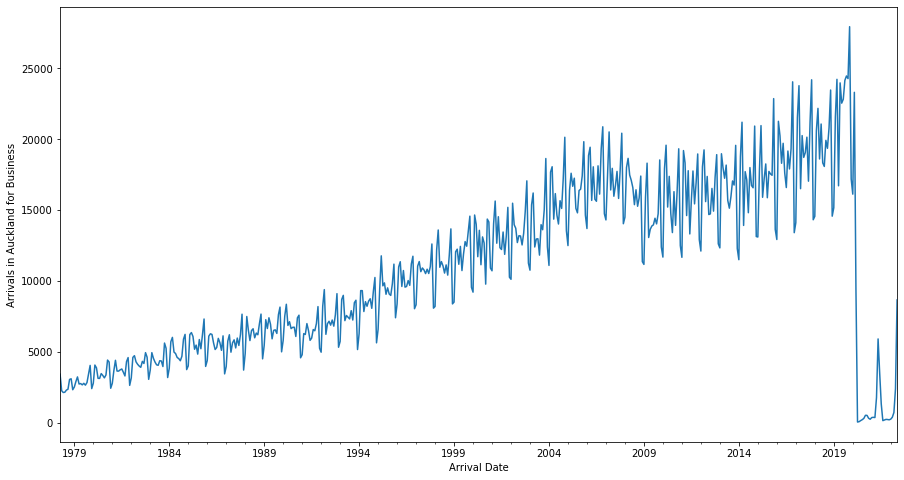

In [85]:
# Lets start with modeling our Auckland data as a test and create a piepeline which will help us speed up the process


arrivals['BusinessAuckland'].plot(figsize = (15,8))
plt.xlabel('Arrival Date')
plt.ylabel('Arrivals in Auckland for Business')
plt.show()

We've made our data have stationarity it's possible we may want to consider NOT calculating the difference from 03/01/2020 due to the massive impact that was made by the COVID-19 Pandemic. This may throw off our future forecasting.

# 2.0 Accomodation-Data